<a href="https://colab.research.google.com/github/kelgruber/hand-gesture-classification/blob/main/Kel_Gruber_Final_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Task 3: Effects of Data Augmentation

Kel Gruber

## Dataset - Hand Gesture Classification

Goal of this project is build a model that correctly classifies images of 5 different hand gestures. Dataset consists of over 2650 digital colored images that belong to 5 classes: dislike, like, peace, one, and stop. 2500 images came from the crowdsourced HaGRID dataset and 150 images were taken by Kel Gruber and classmate volunteers following the Hagrid dataset's collection guidelines.

The 2500 images originally came from this [HaGRID Sample 30k 384p Dataset](https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p) on Kaggle, this sample contains 30,000 images and all 18 classes.

##1. Load Dataset and Preview Original Images Before Data Augmentation
For reproducibility the dataset has been split before we begin into 3 sets, the training, validation and testing sets. The training set contains approximately 60% of the data, and the validation and testing sets each contain 20% of the data.

This task will be completed with the revised dataset from Task 1 with the cropped images. As shown in the Task 1 experiments the original data requires very deep models to learn due to the complexity of the complexity of the original images. In order to analyze and complete the hyperparameter experiments in this task it will be best to use the preprocessed dataset.

### Import libaries and connect to Drive

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Dataset from Drive and Unzip

In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/5390 Final Project/Cropped_Split_Data.zip')
zip_train.extractall('/tmp')
zip_train.close()

###Import Training, Validation, and Testing Datasets

In [ ]:
image_size = 100

image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(training_data.image_shape)

validation_set = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size ), batch_size=1, class_mode='categorical')
print(validation_set.image_shape)

testing_set = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/testing', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(testing_set.image_shape)

Found 1590 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)


###View Some Examples from the Training Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

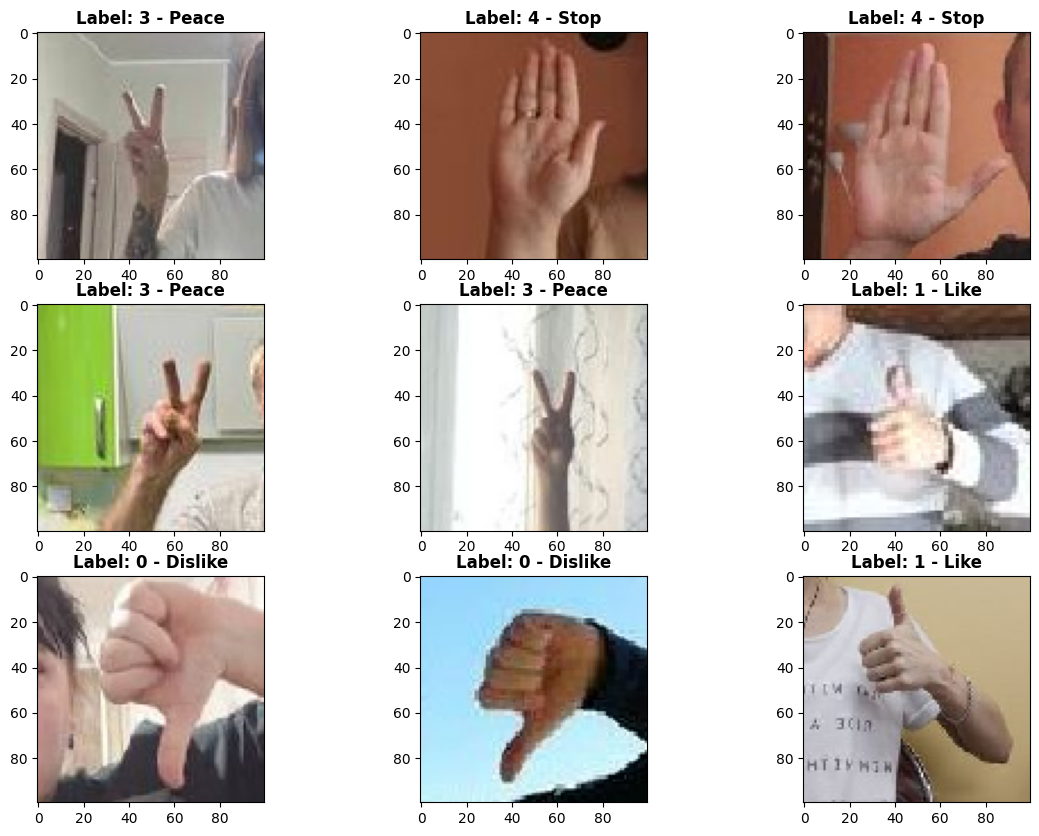

In [ ]:
i = 3
label_category = {0: "Dislike", 1: "Like", 2: "One", 3: "Peace", 4: "Stop"}

images = []
labels = []
for i in range(9):
    image, label = next(training_data)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

##2. Applying Different Data Augmentations

Our goal in this phase is to improve the best model from Phase 2, Model 7 which had a 77.17% accuracy on the validation set and 75.85% testing set by applying various data augmentations. We are augmenting the data using image generators and utilizing early stopping and model checkpointing to prevent overfitting and experimenting with tuning the hyperparameters.

Model Structure:
- 3 Convolutional layers with 200, 100, 50 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (5,5) and (3,3) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function

Below is a diagram of this model's structure.

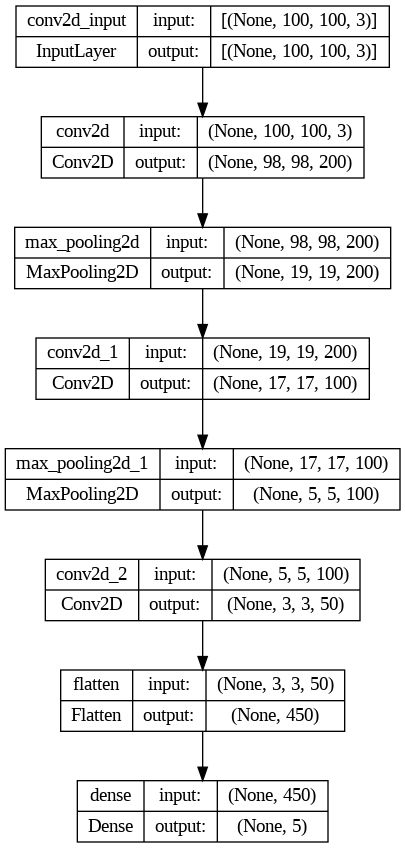

In [ ]:
tf.keras.utils.plot_model(model_1, show_layer_names=True, show_shapes=True)

###2.1 Experiment 1: Shifting and Randomly Flipping Images



####Apply Shift and Horizontal Flip to Images

In [ ]:
# Shift images left/right and up/down and randomly flip some horizontally
shifted_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

In [ ]:
shifted_training = shifted_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(shifted_training.image_shape)

shifted_validation = shifted_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(shifted_validation.image_shape)

Found 1590 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)


####Preview the Shifted and Flipped Images

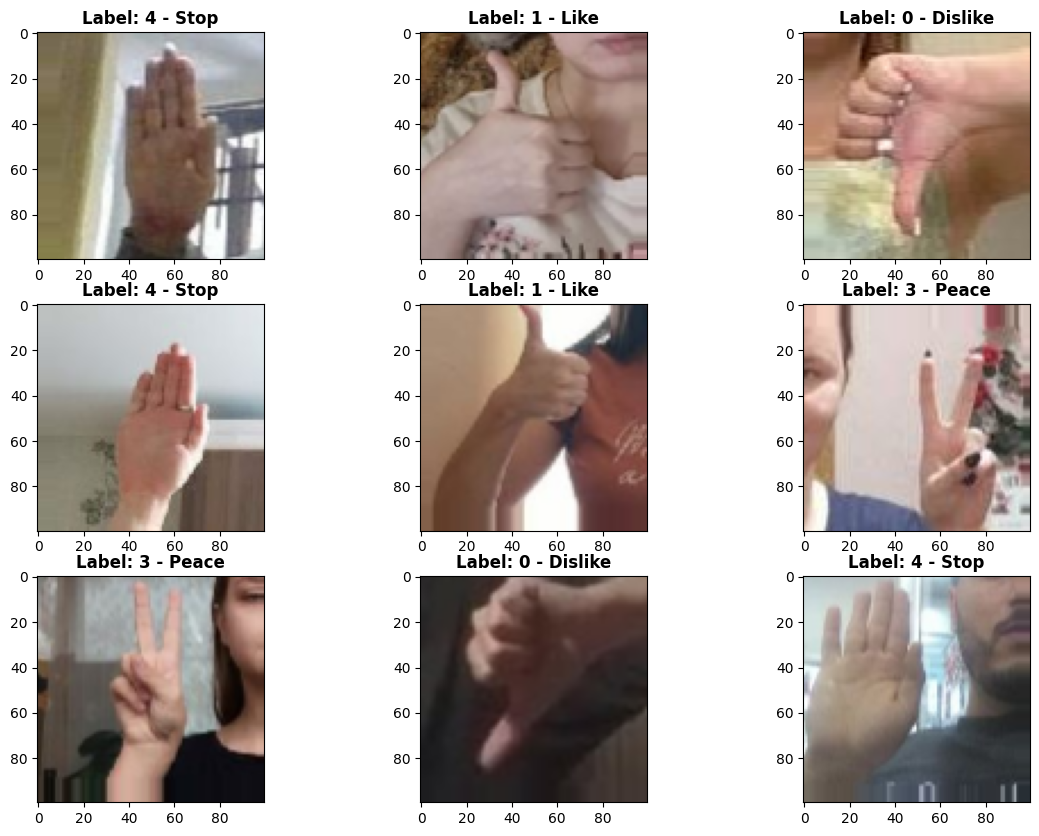

In [ ]:
images = []
labels = []
for i in range(9):
    image, label = next(shifted_training)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

####Build Model

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
model_1 = Sequential()

model_1.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_1.add(layers.MaxPooling2D((5,5)))
model_1.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((3, 3)))
model_1.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_1.add( Flatten() )
model_1.add( Dense(5, activation = 'softmax' ) )

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 200)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 100)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 50)          45050     
                                                                 
 flatten_1 (Flatten)         (None, 450)              

####Train Model

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_1_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history1 = model_1.fit(shifted_training, validation_data = shifted_validation, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1587/1590 [============================>.] - ETA: 0s - loss: 1.5885 - accuracy: 0.2552
Epoch 1: val_loss improved from inf to 1.47935, saving model to model_1_best.hdf5
1590/1590 [==============================] - 17s 10ms/step - loss: 1.5887 - accuracy: 0.2547 - val_loss: 1.4793 - val_accuracy: 0.3717
Epoch 2/100
1590/1590 [==============================] - ETA: 0s - loss: 1.2803 - accuracy: 0.4516
Epoch 2: val_loss improved from 1.47935 to 1.22629, saving model to model_1_best.hdf5
1590/1590 [==============================] - 13s 8ms/step - loss: 1.2803 - accuracy: 0.4516 - val_loss: 1.2263 - val_accuracy: 0.5302
Epoch 3/100
1587/1590 [============================>.] - ETA: 0s - loss: 1.1330 - accuracy: 0.5501
Epoch 3: val_loss improved from 1.22629 to 1.16610, saving model to model_1_best.hdf5
1590/1590 [==============================] - 13s 8ms/step - loss: 1.1338 - accuracy: 0.5497 - val_loss: 1.1661 - val_accuracy: 0.5717
Epoch 4/100
1589/1590 [=======================

####View Learning Curves

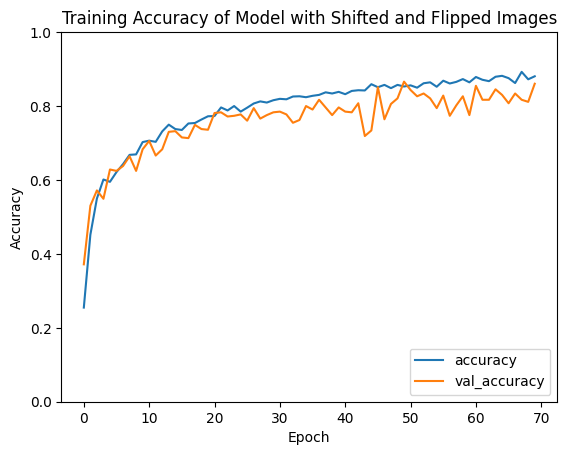

In [ ]:
plt.title('Training Accuracy of Model with Shifted and Flipped Images')
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

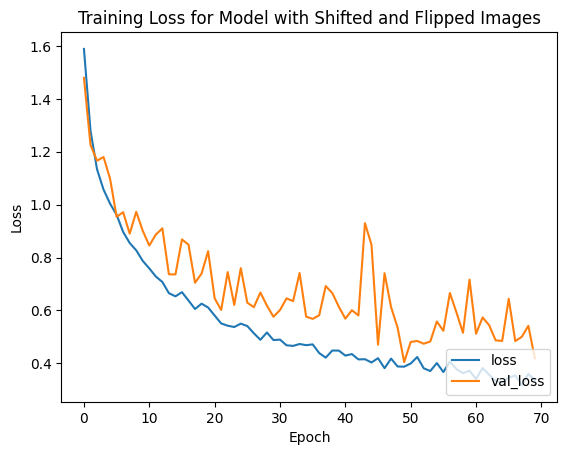

In [ ]:
plt.title('Training Loss for Model with Shifted and Flipped Images')
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_1.load_weights('model_1_best.hdf5')

####Evaluate Model

In [ ]:
val_loss, val_acc = model_1.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.3789 - accuracy: 0.8491
Accuracy: 84.9056601524353
Loss:0.37891995906829834


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_1.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8490566037735849
Precision: 0.8500349595049873
Recall: 0.8490566037735849
F1 Score: 0.8488469580924153


###2.2 Experiment 2: Rotating the Images


####Apply Rotation

In [ ]:
# Add rotation to our images (by 15 degrees).
rotated_generator = ImageDataGenerator(rescale=1./255, rotation_range=25, horizontal_flip=True)

rotated_training = rotated_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(rotated_training.image_shape)

rotated_validation = rotated_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(rotated_validation.image_shape)


Found 1590 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)


####Preview the Rotated Images

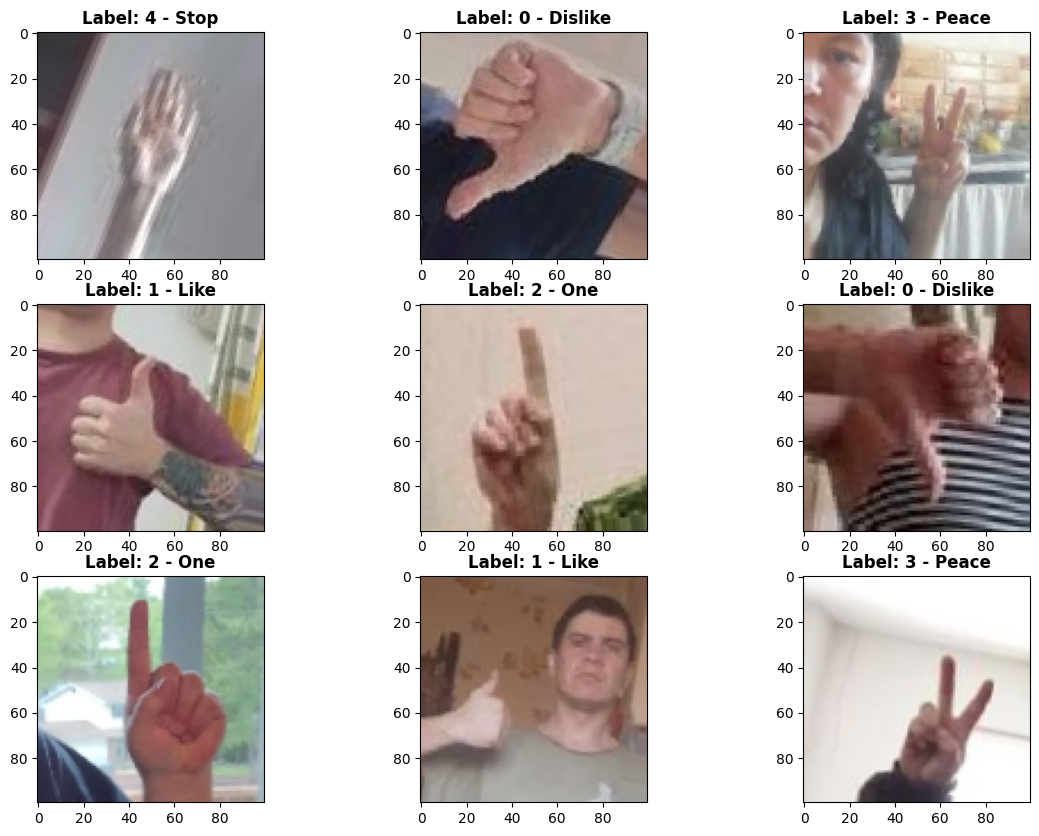

In [ ]:
images = []
labels = []
for i in range(9):
    image, label = next(rotated_training)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

####Build Model

In [ ]:
model_2 = Sequential()

model_2.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape = rotated_training.image_shape))
model_2.add(layers.MaxPooling2D((5,5)))
model_2.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((3, 3)))
model_2.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_2.add( Flatten() )
model_2.add( Dense(5, activation = 'softmax' ) )

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 200)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 100)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 50)          45050     
                                                                 
 flatten_3 (Flatten)         (None, 450)              

####Train Model

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_2_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history2 = model_2.fit(rotated_training, validation_data = rotated_validation, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.5803 - accuracy: 0.2549
Epoch 1: val_loss improved from inf to 1.43152, saving model to model_2_best.hdf5
1590/1590 [==============================] - 17s 9ms/step - loss: 1.5804 - accuracy: 0.2547 - val_loss: 1.4315 - val_accuracy: 0.3736
Epoch 2/100
1590/1590 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.4925
Epoch 2: val_loss improved from 1.43152 to 1.11055, saving model to model_2_best.hdf5
1590/1590 [==============================] - 16s 10ms/step - loss: 1.2296 - accuracy: 0.4925 - val_loss: 1.1106 - val_accuracy: 0.5660
Epoch 3/100
1585/1590 [============================>.] - ETA: 0s - loss: 1.0019 - accuracy: 0.6000
Epoch 3: val_loss improved from 1.11055 to 0.94553, saving model to model_2_best.hdf5
1590/1590 [==============================] - 14s 9ms/step - loss: 1.0020 - accuracy: 0.5987 - val_loss: 0.9455 - val_accuracy: 0.6528
Epoch 4/100
1582/1590 [=======================

####View Learning Curves

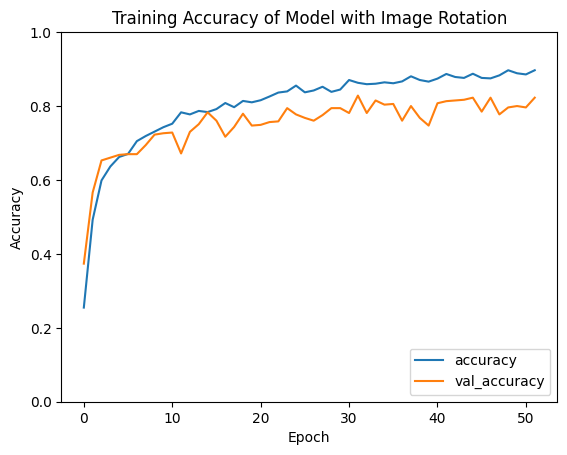

In [ ]:
plt.title('Training Accuracy of Model with Image Rotation')
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

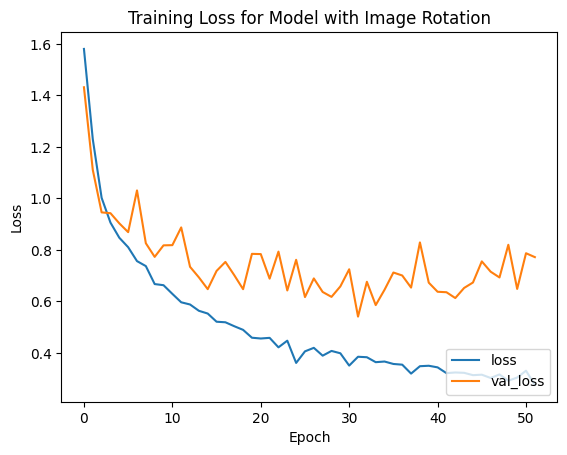

In [ ]:
plt.title('Training Loss for Model with Image Rotation')
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
model_2.load_weights('model_2_best.hdf5')

In [ ]:
val_loss, val_acc = model_2.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.5659 - accuracy: 0.8208
Accuracy: 82.07547068595886
Loss:0.5658872723579407


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_2.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8207547169811321
Precision: 0.8200354810784319
Recall: 0.8207547169811321
F1 Score: 0.8189305340641589


###2.3 Experiment 3: Applying Zoom to the Images



####Apply Zoom to Images

In [ ]:
zoom_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.35)

zoom_training = zoom_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(zoom_training.image_shape)

zoom_validation = zoom_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(zoom_validation.image_shape)


Found 1590 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)


####Preview the Zoomed In Images

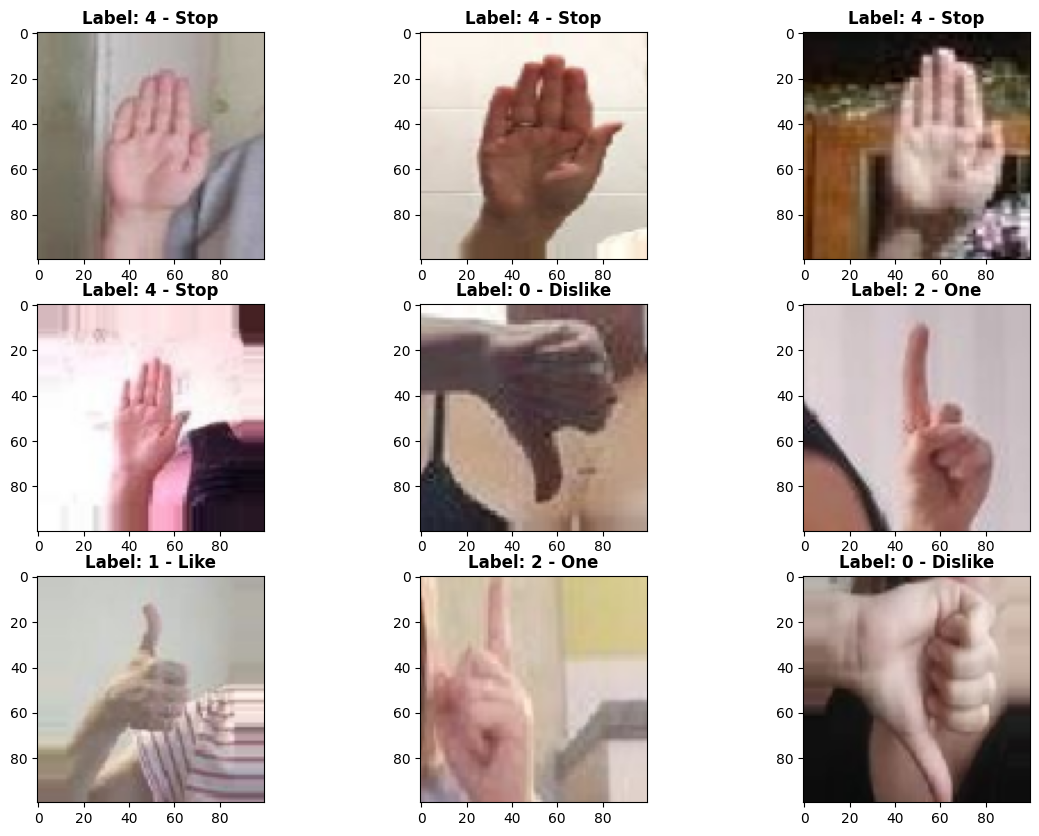

In [ ]:
images = []
labels = []
for i in range(9):
    image, label = next(zoom_training)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

####Build Model

In [ ]:
model_3 = Sequential()

model_3.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape = zoom_training.image_shape))
model_3.add(layers.MaxPooling2D((5,5)))
model_3.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((3, 3)))
model_3.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_3.add( Flatten() )
model_3.add( Dense(5, activation = 'softmax' ) )

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 19, 19, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 100)         0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 50)          45050     
                                                                 
 flatten_5 (Flatten)         (None, 450)              

####Train Model

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_3_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history3 = model_3.fit(zoom_training, validation_data = zoom_validation, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1585/1590 [============================>.] - ETA: 0s - loss: 1.5914 - accuracy: 0.2322
Epoch 1: val_loss improved from inf to 1.41104, saving model to model_3_best.hdf5
1590/1590 [==============================] - 16s 9ms/step - loss: 1.5906 - accuracy: 0.2327 - val_loss: 1.4110 - val_accuracy: 0.4491
Epoch 2/100
1590/1590 [==============================] - ETA: 0s - loss: 1.2242 - accuracy: 0.4981
Epoch 2: val_loss improved from 1.41104 to 1.22299, saving model to model_3_best.hdf5
1590/1590 [==============================] - 14s 9ms/step - loss: 1.2242 - accuracy: 0.4981 - val_loss: 1.2230 - val_accuracy: 0.5113
Epoch 3/100
1585/1590 [============================>.] - ETA: 0s - loss: 1.0399 - accuracy: 0.5975
Epoch 3: val_loss improved from 1.22299 to 1.06381, saving model to model_3_best.hdf5
1590/1590 [==============================] - 15s 9ms/step - loss: 1.0400 - accuracy: 0.5969 - val_loss: 1.0638 - val_accuracy: 0.5642
Epoch 4/100
1584/1590 [========================

####View Learning Curves

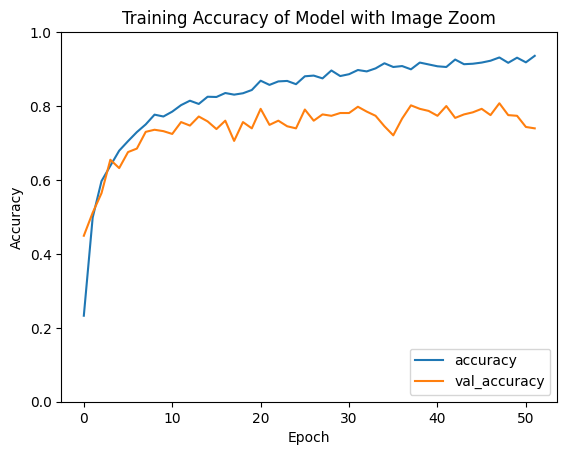

In [ ]:
plt.title('Training Accuracy of Model with Image Zoom')
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

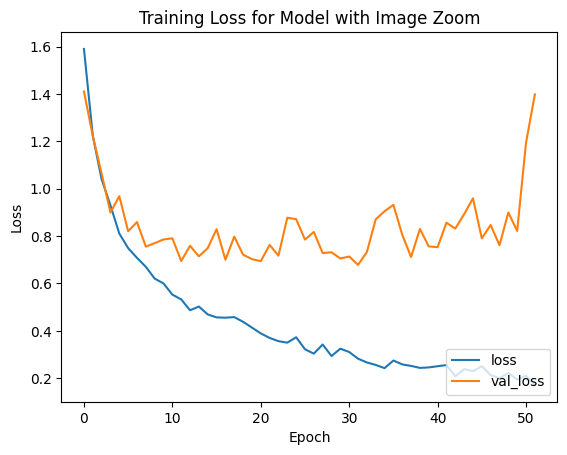

In [ ]:
plt.title('Training Loss for Model with Image Zoom')
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
model_3.load_weights('model_3_best.hdf5')

In [ ]:
val_loss, val_acc = model_3.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.6216 - accuracy: 0.8113
Accuracy: 81.13207817077637
Loss:0.6216175556182861


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_3.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8113207547169812
Precision: 0.8094903829446787
Recall: 0.8113207547169812
F1 Score: 0.8095338056247856


###2.4 Experiment 4: Applying All Augmentation Techniques to the Data



####Apply Shift, Flip, Rotation, and Zoom to Images

In [ ]:
zoom_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.35, rotation_range=25, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

all_training = zoom_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(zoom_training.image_shape)

all_validation = zoom_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(zoom_validation.image_shape)



Found 1590 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)


####Preview some Augmented Images

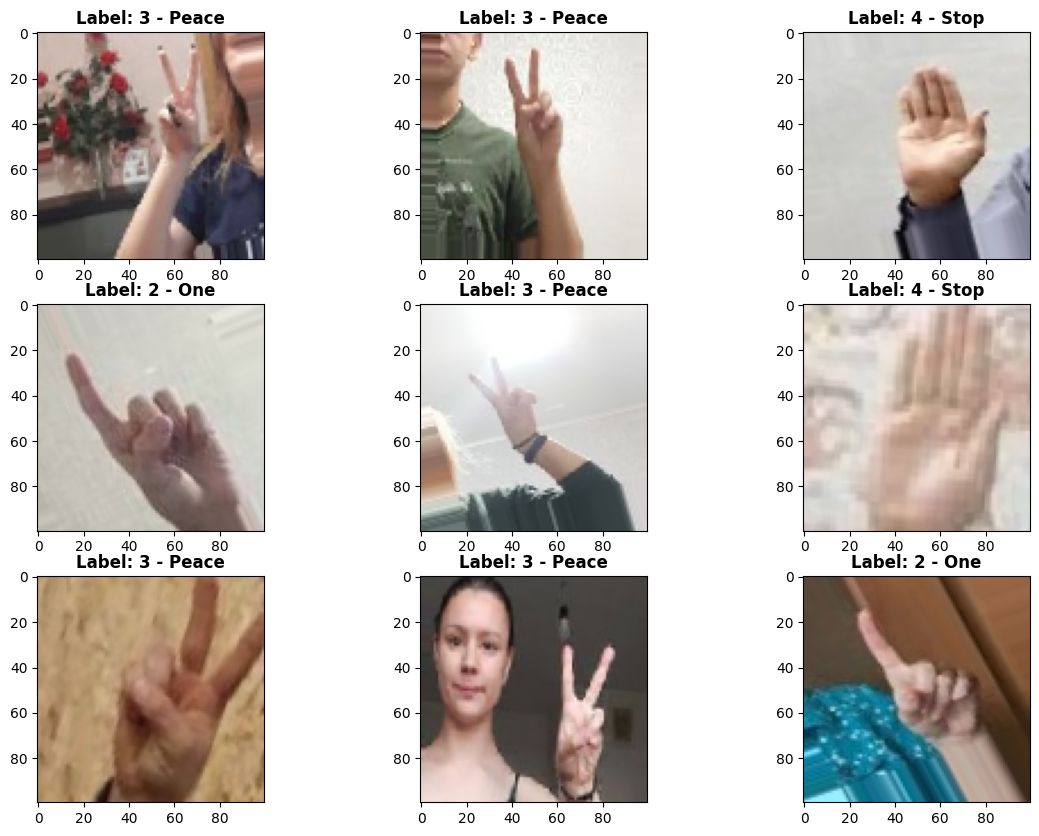

In [ ]:
images = []
labels = []
for i in range(9):
    image, label = next(all_training)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

####Build Model

In [ ]:
model_5 = Sequential()

model_5.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape = all_training.image_shape))
model_5.add(layers.MaxPooling2D((5,5)))
model_5.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((3, 3)))
model_5.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_5.add( Flatten() )
model_5.add( Dense(5, activation = 'softmax' ) )

model_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 19, 19, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 5, 5, 100)         0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 3, 50)          45050     
                                                                 
 flatten_6 (Flatten)         (None, 450)              

####Train Model

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_5_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history5 = model_5.fit(all_training, validation_data = all_validation, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.6164 - accuracy: 0.2018
Epoch 1: val_loss improved from inf to 1.60966, saving model to model_5_best.hdf5
1590/1590 [==============================] - 17s 10ms/step - loss: 1.6163 - accuracy: 0.2031 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 2/100
1587/1590 [============================>.] - ETA: 0s - loss: 1.5476 - accuracy: 0.2968
Epoch 2: val_loss improved from 1.60966 to 1.56112, saving model to model_5_best.hdf5
1590/1590 [==============================] - 15s 9ms/step - loss: 1.5477 - accuracy: 0.2975 - val_loss: 1.5611 - val_accuracy: 0.3094
Epoch 3/100
1583/1590 [============================>.] - ETA: 0s - loss: 1.4712 - accuracy: 0.3594
Epoch 3: val_loss improved from 1.56112 to 1.44535, saving model to model_5_best.hdf5
1590/1590 [==============================] - 15s 10ms/step - loss: 1.4702 - accuracy: 0.3597 - val_loss: 1.4453 - val_accuracy: 0.3943
Epoch 4/100
1584/1590 [======================

####View Learning Curves

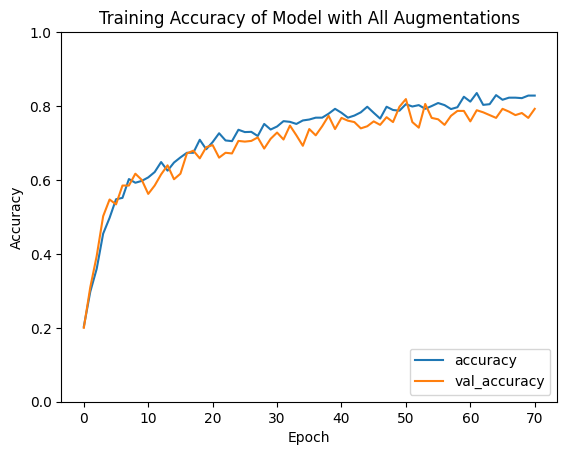

In [ ]:
plt.title('Training Accuracy of Model with All Augmentations')
plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

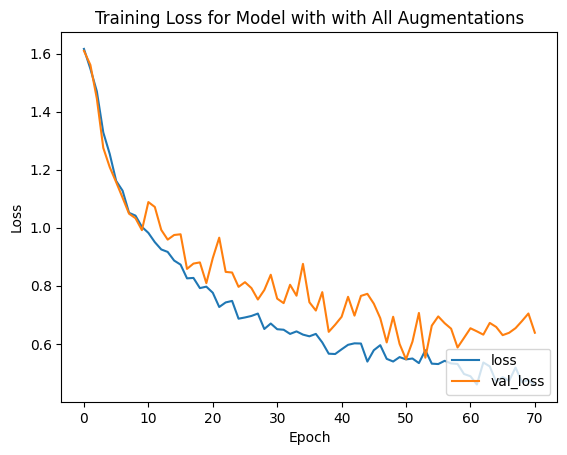

In [ ]:
plt.title('Training Loss for Model with with All Augmentations')
plt.plot(history5.history['loss'], label='loss')
plt.plot(history5.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
model_5.load_weights('model_5_best.hdf5')

In [ ]:
val_loss, val_acc = model_5.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.4214 - accuracy: 0.8604
Accuracy: 86.03773713111877
Loss:0.42136484384536743


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_5.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8603773584905661
Precision: 0.8660251107065259
Recall: 0.8603773584905661
F1 Score: 0.8603950829839565


###2.5 Experiment 5: Reducing the Color Channels
In this experiment we will see if color plays an important role in our model or not.

####Reduce the Color Channels from 3 to 1

In [ ]:
bnw_training = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical', color_mode='grayscale')
print(bnw_training.image_shape)

bnw_validation = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size), batch_size=1, class_mode='categorical', color_mode='grayscale')
print(bnw_validation.image_shape)

bnw_testing = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/testing', target_size=(image_size , image_size), batch_size=1, class_mode='categorical', color_mode='grayscale')
print(bnw_testing.image_shape)

Found 1590 images belonging to 5 classes.
(100, 100, 1)
Found 530 images belonging to 5 classes.
(100, 100, 1)
Found 530 images belonging to 5 classes.
(100, 100, 1)


####Preview the Black and White

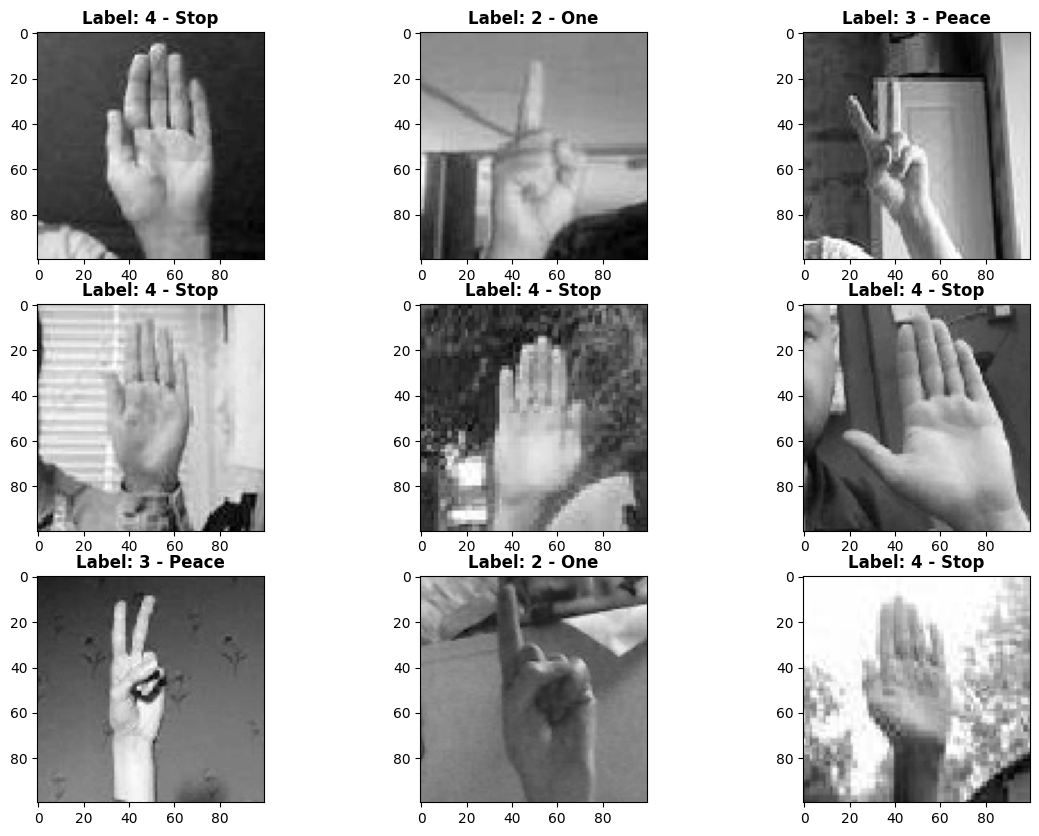

In [ ]:
images = []
labels = []
for i in range(9):
    image, label = next(bnw_training)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze(), cmap='gray')
plt.show()

####Build Model

In [ ]:
model_4 = Sequential()

model_4.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape = bnw_training.image_shape))
model_4.add(layers.MaxPooling2D((5,5)))
model_4.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((3, 3)))
model_4.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_4.add( Flatten() )
model_4.add( Dense(5, activation = 'softmax' ) )

model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 98, 98, 200)       2000      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 19, 19, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 5, 5, 100)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 3, 3, 50)          45050     
                                                                 
 flatten_7 (Flatten)         (None, 450)              

####Train Model

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_4_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history4 = model_4.fit(bnw_training, validation_data = bnw_validation, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1582/1590 [============================>.] - ETA: 0s - loss: 1.4575 - accuracy: 0.3527
Epoch 1: val_loss improved from inf to 1.22923, saving model to model_4_best.hdf5
1590/1590 [==============================] - 12s 7ms/step - loss: 1.4548 - accuracy: 0.3541 - val_loss: 1.2292 - val_accuracy: 0.5094
Epoch 2/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.0981 - accuracy: 0.5802
Epoch 2: val_loss improved from 1.22923 to 1.11976, saving model to model_4_best.hdf5
1590/1590 [==============================] - 12s 7ms/step - loss: 1.0974 - accuracy: 0.5805 - val_loss: 1.1198 - val_accuracy: 0.5698
Epoch 3/100
1581/1590 [============================>.] - ETA: 0s - loss: 0.8524 - accuracy: 0.6743
Epoch 3: val_loss improved from 1.11976 to 0.90079, saving model to model_4_best.hdf5
1590/1590 [==============================] - 10s 6ms/step - loss: 0.8535 - accuracy: 0.6748 - val_loss: 0.9008 - val_accuracy: 0.6811
Epoch 4/100
1584/1590 [========================

####View Learning Curves

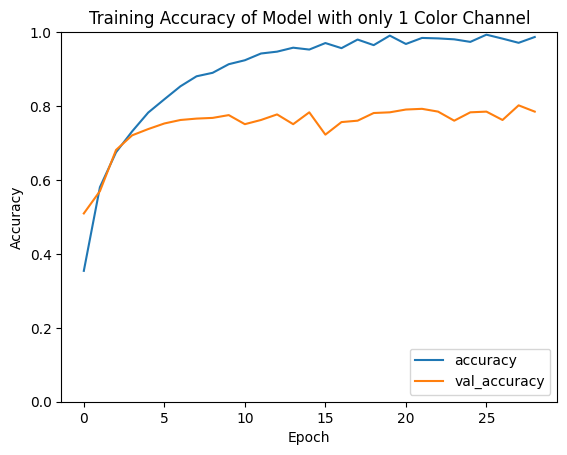

In [ ]:
plt.title('Training Accuracy of Model with only 1 Color Channel')
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

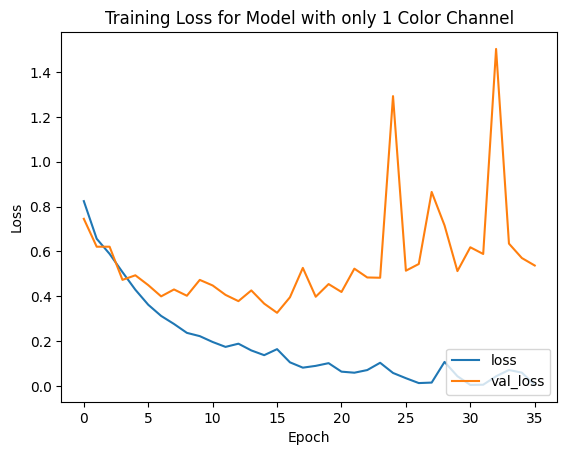

In [ ]:
plt.title('Training Loss for Model with only 1 Color Channel')
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
model_4.load_weights('model_4_best.hdf5')

In [ ]:
val_loss, val_acc = model_4.evaluate(bnw_validation)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.7407 - accuracy: 0.7679
Accuracy: 76.79245471954346
Loss:0.7407211661338806


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(bnw_validation)):
   x, y = bnw_validation.next()
   p = model_4.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7679245283018868
Precision: 0.7708244204562051
Recall: 0.7679245283018868
F1 Score: 0.7691021568925606


##3. REWRITE THIS Conclusion

REWRITE THIS
Almost all of the data augmentations improved the model’s overall results on
the validation set by several percentage points. The image shifting, flipping,
rotation, and zoom augmentation all had similar results of about 94.5-95%
accuracy on the validation set. The only augmentation where the model
performed worse overall was when the input was reduced to one color channel
essentially converting the color images into black and white images. This
model performed slightly worse than the original model. It’s possible that
color is being used by the model to identify differences between the bears so
when the images are converted to black and white it becomes more difficult for
the model to learn how to identify the bears.
